<a href="https://colab.research.google.com/github/novandi18/exoplanet-habitability-prediction-rnn-knn/blob/master/Exoplanet_Habitability_Prediction_with_RNN_and_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikeras
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Dataset: https://www.kaggle.com/datasets/diaaessam/exoplanets-planets-outside-our-galaxy
import pandas as pd

df = pd.read_csv('exoplanet/exoplanets.csv')
new_columns = {'Host star mass (M☉)': 'Host star mass'}
df = df.rename(columns=new_columns)

# Hapus kolom yang tidak perlu
df.drop(['Remarks', 'Disc. Year', 'Discovery method'], axis=1, inplace=True)

df.head()

,Name,Mass (MJ),Radius (RJ),Period (days),Semi-major axis (AU),Temp. (K),Distance (ly),Host star mass,Host star temp. (K)
0,16 Cygni Bb,2.38,NaN,799.5,1.66,NaN,68.99,1.04,5750
1,23 Librae b,1.61,NaN,258.18,0.81,NaN,85.46,1.07,5736
2,47 Ursae Majoris b,2.53,NaN,1078,2.1,NaN,45.02,1.08,5892
3,51 Pegasi b,0.46,NaN,4.230785,0.0527,NaN,50.45,1.12,5793
4,55 Cancri b,0.8306,NaN,14.65152,0.115227,700,41.06,0.905,5196


In [ ]:
from numpy import nan

def clean_distance(arg):
  if not isinstance(arg, str):
    return arg
  arg = arg.replace(',', '')
  if '±' in arg:
    pieces = arg.split('±')
    if pieces[0] != '':
      return float(pieces[0])
    else:
      return float(pieces[1])
  if 'ly' in arg:
    return float(arg.split('ly')[0])
  try:
      return float(arg)
  except:
      return nan

def clean_mass(arg):
  if not isinstance(arg, str):
    return arg
  arg = arg.replace('~', '').replace('{', '').replace('}', '').replace(',', '')
  if arg in {'10-May', 'Imaged near Alpha Centauri A'}:
    return nan
  if 'E' in arg:
    return float(arg)
  if '+' in arg:
    return float(arg.split('+')[0])
  if '-' in arg:
    if '±' in arg:
        arg = arg.split('±')[0]
    return float(arg.split('-')[0])
  if '±' in arg:
    pieces = arg.split('±')
    if pieces[0].strip() != '':
      return float(pieces[0].strip())
    else:
      return float(pieces[1].strip())
  if '[' in arg:
    return float(arg.split('[')[0])
  if '<' in arg:
    return float(arg.replace('<', ''))
  if '>' in arg:
    return float(arg.split('>')[1])
  if '/' in arg:
    return float(arg.split('/')[0])
  try:
      return float(arg)
  except:
      return nan

df['Mass (MJ)'] = df['Mass (MJ)'].apply(func=clean_mass)
df['Radius (RJ)'] = df['Radius (RJ)'].apply(func=clean_mass)
df['Period (days)'] = df['Period (days)'].apply(func=clean_mass)
df['Semi-major axis (AU)'] = df['Semi-major axis (AU)'].apply(func=clean_mass)
df['Distance (ly)'] = df['Distance (ly)'].apply(func=clean_distance)
df['Temp. (K)'] = df['Temp. (K)'].apply(func=clean_mass)
df['Host star temp. (K)'] = df['Host star temp. (K)'].apply(func=clean_mass)
df['Host star mass'] = df['Host star mass'].apply(func=clean_mass)

df['Mass (MJ)'] = df['Mass (MJ)'].fillna(df['Mass (MJ)'].median())
df['Temp. (K)'] = df['Temp. (K)'].fillna(df['Temp. (K)'].mean())
df['Host star temp. (K)'] = df['Host star temp. (K)'].fillna(df['Host star temp. (K)'].mean())

df['Mass-Radius Ratio'] = df['Mass (MJ)'] / df['Radius (RJ)']

df = df.dropna()
df.head()

,Name,Mass (MJ),Radius (RJ),Period (days),Semi-major axis (AU),Temp. (K),Distance (ly),Host star mass,Host star temp. (K),Mass-Radius Ratio
18,HD 209458 b,0.73000,1.39,3.524749,0.047070,1459.000000,157.80,1.23,6091.0,0.525180
21,HD 222582 b,8.37000,1.12,572.380000,1.340000,1100.349013,137.70,1.12,5790.0,7.473214
29,Upsilon Andromedae b,0.68760,1.80,4.617033,0.059222,1100.349013,43.74,1.30,6183.0,0.382000
31,Upsilon Andromedae d,4.13200,1.02,1276.460000,2.513290,1100.349013,43.74,1.30,6183.0,4.050980
53,55 Cancri e,0.02542,0.17,0.736539,0.015440,1958.000000,41.06,0.91,5196.0,0.149529


In [ ]:
df.to_csv('exoplanet/exoplanets_clean.csv', index=False)

In [ ]:
features = df[['Mass (MJ)', 'Radius (RJ)', 'Period (days)', 'Semi-major axis (AU)', 'Distance (ly)', 'Host star temp. (K)', 'Host star mass', 'Mass-Radius Ratio']]
target = df['Temp. (K)']

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
scaler.fit(target.to_numpy().reshape(-1, 1))
target_scaled = scaler.fit_transform(target.to_numpy().reshape(-1, 1))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_scaled, test_size=0.2, random_state=42)

In [ ]:
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1), kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(LSTM(50, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_regularizer=l2(0.001)))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping])
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1142 - val_loss: 0.0514
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0466 - val_loss: 0.0295
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0272 - val_loss: 0.0187
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0196 - val_loss: 0.0136
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0143 - val_loss: 0.0113
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0122 - val_loss: 0.0105
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0111 - val_loss: 0.0092
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0109 - val_loss: 0.0089
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0092 - val_loss: 0.0085
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0117 - val_loss: 0.0084
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0093 - val_loss: 0.0088
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

In [ ]:
loss = model.evaluate(X_test_reshaped, y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071 


In [ ]:
predictions = model.predict(X_test_reshaped)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [ ]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score, KFold
from keras.layers import LSTM, Dense

# Bungkus model Keras dengan KerasRegressor
keras_model = KerasRegressor(build_fn=model, epochs=100, batch_size=32, verbose=0)

# Tentukan jumlah fold untuk K-Fold Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Lakukan cross-validation dan hitung skor
scores = cross_val_score(keras_model, features_scaled, target_scaled, cv=kfold, scoring='neg_mean_squared_error')

In [ ]:
# Tampilkan hasil cross-validation
print(f"Hasil Cross-Validation: {scores}")
print(f"Rata-rata MSE: {-scores.mean()}, Standar Deviasi: {scores.std()}")

Hasil Cross-Validation: [-0.00662905 -0.00640698 -0.00761979 -0.00625186 -0.00613087]
Rata-rata MSE: 0.006607710445941839, Standar Deviasi: 0.000532738568434458


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Invers transformasi untuk mendapatkan nilai suhu asli
predictions_inversed = scaler.inverse_transform(predictions)
y_test_inversed = scaler.inverse_transform(y_test)

# Hitung MAE dan RMSE
mae = mean_absolute_error(y_test_inversed, predictions_inversed)
rmse = mean_squared_error(y_test_inversed, predictions_inversed, squared=False)

print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

Mean Absolute Error (MAE): 217.0278
Root Mean Squared Error (RMSE): 316.5183


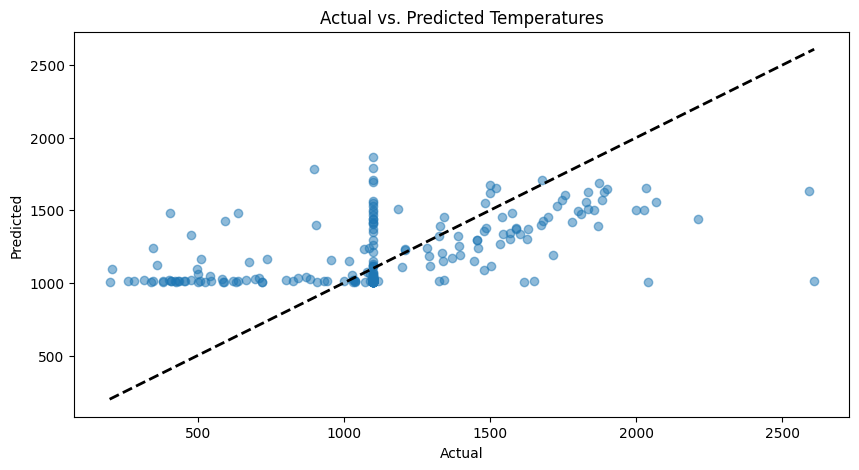

In [ ]:
import matplotlib.pyplot as plt

# Plot prediksi vs nilai sebenarnya
plt.figure(figsize=(10, 5))
plt.scatter(y_test_inversed, predictions_inversed, alpha=0.5)
plt.plot([y_test_inversed.min(), y_test_inversed.max()], [y_test_inversed.min(), y_test_inversed.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Temperatures')
plt.show()

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0074 - val_loss: 0.0061
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0074 - val_loss: 0.0063
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0078 - val_loss: 0.0062
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071 - val_loss: 0.0066
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070 - val_loss: 0.0078
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0081 - val_loss: 0.0061
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069 - val_loss: 0.0063
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070 - val_loss: 0.0062
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0085 - val_loss: 0.0065
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0073 - val_loss: 0.0062


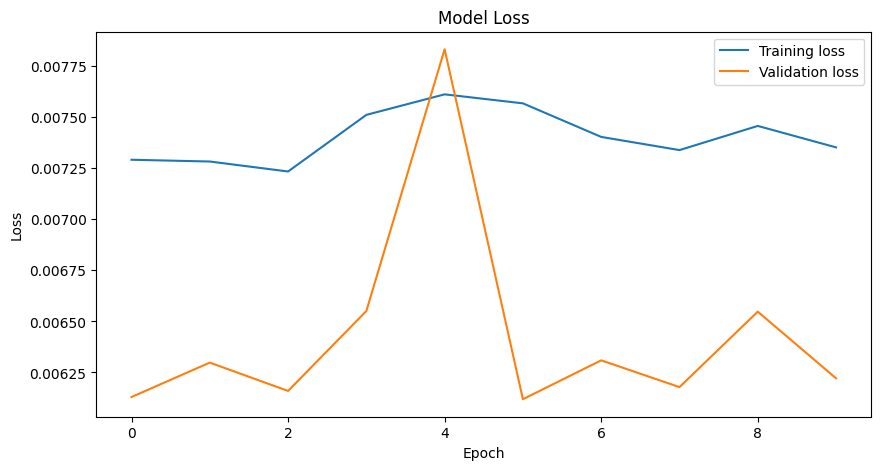

In [ ]:
# Menyimpan hasil dari fungsi fit model
history = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:
from keras.models import load_model

# Simpan model prediksi
model.save('exoplanet/model.keras')
model = load_model('exoplanet/model.keras')

In [ ]:
# Simpan nilai min dan max dari setiap fitur ke dalam file CSV
min_max_values = {}
for feature in features:
  min_max_values[feature] = {'min': df[feature].min(), 'max': df[feature].max()}

df_min_max = pd.DataFrame(min_max_values).T
df_min_max.to_csv('exoplanet/min_max_values.csv', index_label='Feature')

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def predict_exoplanet_temperature(data_input):
  # Muat nilai min dan max dari file CSV
  df_min_max = pd.read_csv('exoplanet/min_max_values.csv', index_col='Feature')

  # Inisialisasi MinMaxScaler dengan nilai min dan max
  scaler = MinMaxScaler()
  scaler.min_ = df_min_max['min'].values
  scaler.scale_ = 1 / (df_min_max['max'] - df_min_max['min']).values

  # Normalisasi data input
  data_scaled = scaler.transform(data_input)

  # Ubah bentuk data untuk sesuai dengan input model
  data_reshaped = data_scaled.reshape((data_scaled.shape[0], data_scaled.shape[1], 1))

  # Buat prediksi dengan model
  predictions = model.predict(data_reshaped)

  # Siapkan array kosong dengan bentuk yang sama seperti data input yang dinormalisasi
  dummy_features = np.zeros_like(data_scaled)

  # Tempatkan prediksi di kolom terakhir dari array dummy
  dummy_features[:, -1] = predictions.flatten()

  # Lakukan invers transformasi menggunakan array dummy
  predictions_inversed = scaler.inverse_transform(dummy_features)[:, -1]

  return predictions_inversed.reshape(-1, 1)

In [ ]:
# Asumsi bahwa suhu layak huni berada dalam kisaran suhu air cair pada
# tekanan atmosfer standar Bumi, yaitu antara 273.15 K (0 °C) dan 373.15 K (100 °C).
def classify_habitability(temperature_c):
    if 0 <= temperature_c <= 100:
        return "Layak huni oleh manusia"
    else:
        return "Tidak layak huni oleh manusia"

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Fungsi untuk menemukan exoplanet yang mirip
def find_similar_exoplanets(input_features, n_neighbors=3):
    # Muat dataset lengkap
    df_full = pd.read_csv('exoplanet/exoplanets_clean.csv')

    features_full = df_full[['Mass (MJ)', 'Radius (RJ)', 'Period (days)', 'Semi-major axis (AU)', 'Distance (ly)', 'Temp. (K)', 'Host star temp. (K)', 'Host star mass']]

    # Normalisasi fitur menggunakan MinMaxScaler yang sama
    scaler_full = MinMaxScaler()
    features_full_scaled = scaler_full.fit_transform(features_full)

    # Inisialisasi NearestNeighbors
    neighbors = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(features_full_scaled)

    # Cari n terdekat
    distances, indices = neighbors.kneighbors(input_features)

    # Dapatkan nama exoplanet
    similar_exoplanets = df_full.iloc[indices[0]].values.tolist()

    return similar_exoplanets

In [ ]:
# Contoh penggunaan
mass_mj = 1.4  # Massa eksoplanet dalam satuan massa Jupiter (estimasi)
radius_rj = 0.849  # Radius eksoplanet dalam satuan radius Jupiter
period_days = 289.9  # Periode orbit eksoplanet dalam hari
semi_major_axis_au = 0.95  # Semi-major axis eksoplanet dalam AU
distance_ly = 12  # Jarak eksoplanet dari Bumi dalam tahun cahaya
host_star_temp_k = 8511  # Suhu bintang induk dalam Kelvin
host_star_mass = 0.10  # Massa bintang induk dalam satuan massa Matahari
mass_radius_ratio = mass_mj / radius_rj  # Hitung kepadatan planet

# Menggabungkan semua variabel ke dalam satu array NumPy
new_data = np.array([[mass_mj, radius_rj, period_days, semi_major_axis_au, distance_ly, host_star_temp_k, host_star_mass, mass_radius_ratio]])

# Lakukan prediksi suhu
predicted_temperature_k = predict_exoplanet_temperature(new_data)[0][0]
predicted_temperature_c = predicted_temperature_k - 273.15
habitability = classify_habitability(np.round(predicted_temperature_c, 2))

# Tampilkan hasil prediksi suhu
print(f"Prediksi Suhu Eksoplanet (Kelvin): {np.round(predicted_temperature_k, 2)} °K")
print(f"Prediksi Suhu Eksoplanet (Celcius): {np.round(predicted_temperature_c, 2)} °C")
print(habitability)

# Menggabungkan semua variabel ke dalam satu array NumPy untuk exoplanet yang mirip
new_data_new = np.array([[mass_mj, radius_rj, period_days, semi_major_axis_au, distance_ly, predicted_temperature_k, host_star_temp_k, host_star_mass]])

# Temukan 3 exoplanet yang mirip
print("Exoplanet dengan karakteristik serupa:")
similar_exoplanets = find_similar_exoplanets(new_data_new)
for exoplanet in similar_exoplanets:
    print(exoplanet)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Prediksi Suhu Eksoplanet (Kelvin): 273.09 °K
Prediksi Suhu Eksoplanet (Celcius): -0.06 °C
Tidak layak huni oleh manusia
Exoplanet dengan karakteristik serupa:
['Kepler-70c', 0.0021, 0.077, 0.342887, 0.0076, 1100.349012797075, 3849.0, 0.5, 27730.0, 0.0272727272727272]
['Kepler-70b', 0.0014, 0.068, 0.240104, 0.006, 1100.349012797075, 3849.0, 0.5, 27730.0, 0.0205882352941176]
['KELT-9b', 2.88, 1.891, 1.4811235, 0.03462, 4050.0, 615.5, 2.52, 10170.0, 1.5230037017451084]
